In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(123)

def initial_spins(L):
    return np.random.choice([1, -1], size=(L, L, L))

def calculate_energy(spins, K_nn, K_nnn, h, L):
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                energy -= h*spins[i, j, k]
                energy -= K_nn*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L])  # nearest neighbors
                energy -= K_nnn*(spins[(i+2)%L, j, k] + spins[i, (j+2)%L, k] + spins[i, j, (k+2)%L]) # nnn

    return energy

def calculate_energy_fast(spins, K_nn, K_nnn, h, L, i, j, k):
    energy = -h*spins[i, j, k]
    energy -= K_nn*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L] +
                        spins[(i - 1) % L, j, k] +  spins[i, (j-1)%L, k] + spins[i, j, (k-1)%L])
    energy -= K_nnn*(spins[(i+2)%L, j, k] + spins[i, (j+2)%L, k] + spins[i, j, (k+2)%L] +
                         spins[(i-2)%L, j, k] + spins[i, (j-2)%L, k] + spins[i, j, (k-2)%L] +
                         spins[(i+1)%L, j, (k+1)%L] + spins[(i+1)%L, j, (k-1)%L] +
                         spins[(i-1)%L, j, (k+1)%L] + spins[(i-1)%L, j, (k-1)%L] +
                         spins[(i+1)%L, (j+1)%L, k] + spins[(i+1)%L, (j-1)%L, k] +
                         spins[(i-1)%L, (j+1)%L, k] + spins[(i-1)%L, (j-1)%L, k] +
                         spins[i, (j+1)%L, (k+1)%L] + spins[i, (j+1)%L, (k-1)%L] +
                         spins[i, (j-1)%L, (k+1)%L] + spins[i, (j-1)%L, (k-1)%L]
                        )
    return energy

def metropolis_algorithim(spins, beta, K_nn, K_nnn, h, L):
    #making a trial flip
    i, j, k = np.random.randint(0, L, size=3)
    site = spins[i, j, k]
    trial_flip = site * -1
    tfs = spins.copy()  # trial flip spins
    tfs[i, j, k] = trial_flip

    # Computing delta_E:
    old_energy = calculate_energy_fast(spins, K_nn, K_nnn, h, L, i, j, k)
    new_energy = calculate_energy_fast(tfs, K_nn, K_nnn, h, L, i, j, k)
    delta_energy = new_energy - old_energy
    
    # deciding if we should accept the change
    if delta_energy < 0:
        spins[i, j, k] = trial_flip

    else:
        w = np.exp(-beta*delta_energy)
        r = random.random()
        if r <= w:
            spins[i, j, k] = trial_flip

    return(spins)

def monte_carlo(beta, K_nn, K_nnn, h, L, steps, spins):
    energies = [calculate_energy(spins, K_nn, K_nnn, h, L)]
    for step in tqdm(range(steps)):
        spins = metropolis_algorithim(spins, beta, K_nn, K_nnn, h, L)
        if step % 100 == 0:
            energies.append(calculate_energy(spins, K_nn, K_nnn, h, L))
    return spins, energies

In [22]:
def scatter_3D(data, ax, title):
    x = np.indices(data.shape)[0]
    y = np.indices(data.shape)[1]
    z = np.indices(data.shape)[2]
    col = data.flatten()
    
    # 3D Plot
    p3d = ax.scatter(x, y, z, c=col, cmap="PiYG", vmin=-1, vmax=1)
    ax.grid(False)
    plt.colorbar(p3d, label="Spin")
    # plt.clim(-1, 1)
    ax.set_title(title)
    return

100%|████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12220.00it/s]


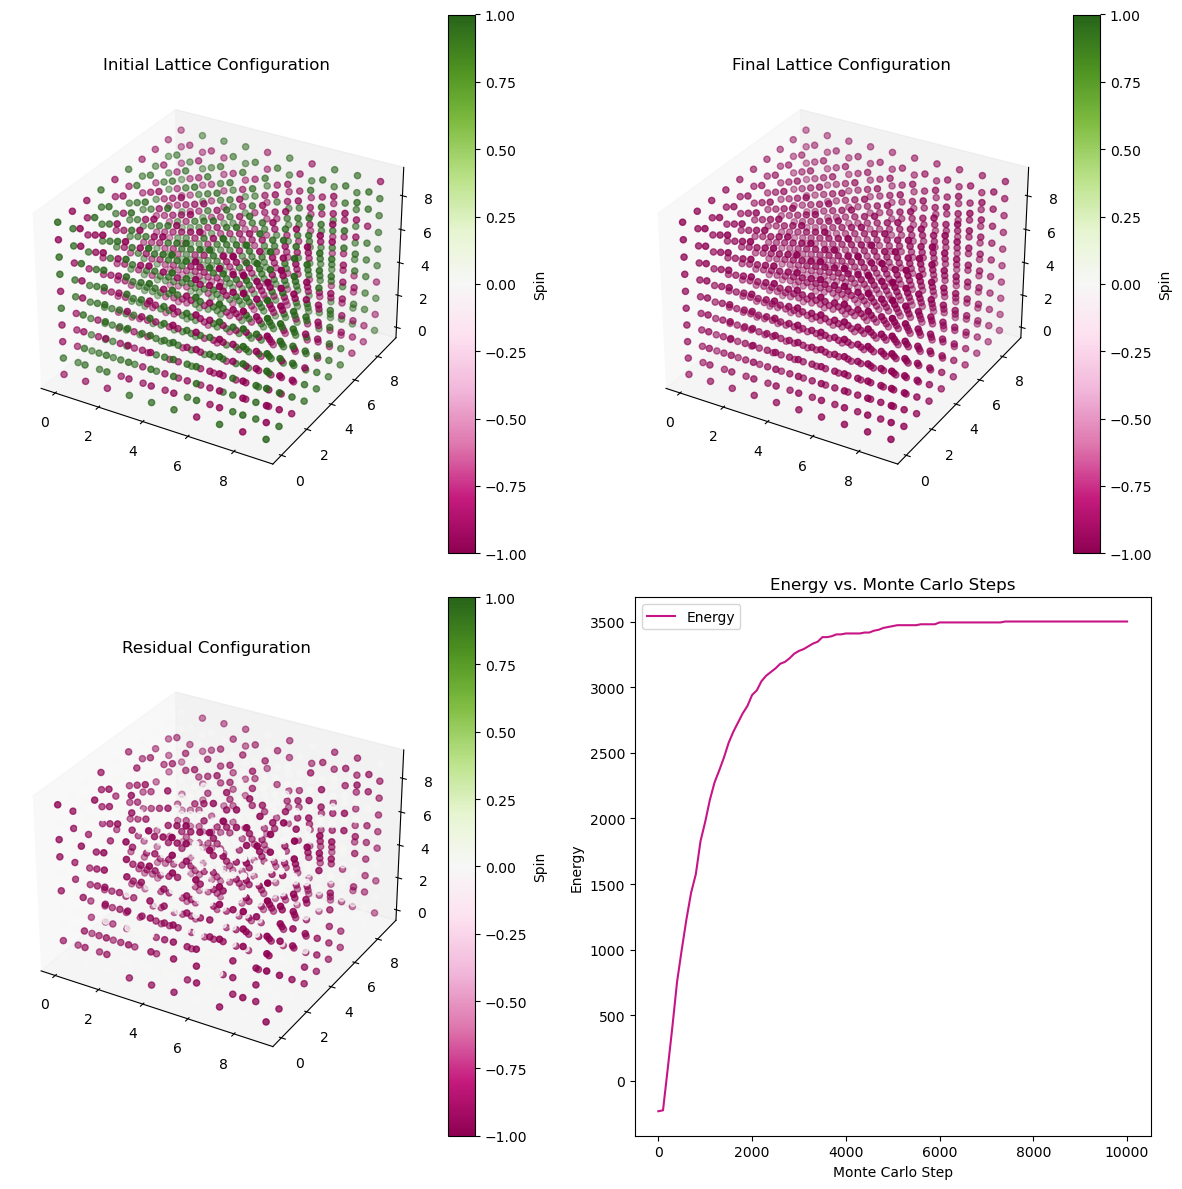

In [27]:
beta = 100000
K_nn = 1
K_nnn = 0.5
h = -1
L = 10
steps = 10000
spins_initial = initial_spins(L)

copy_of_spins_initial = spins_initial.copy()

final_spins, energies = monte_carlo(beta, K_nn, K_nnn, h, L, steps, spins_initial)

# Visualization
cmap = "PiYG"
fig = plt.figure(figsize=(12, 12))

ax0 = fig.add_subplot(2, 2, 1, projection='3d')
scatter_3D(copy_of_spins_initial, ax0, "Initial Lattice Configuration")

ax1 = plt.subplot(2, 2, 2, projection='3d')
scatter_3D(final_spins, ax1, "Final Lattice Configuration")

ax2 = plt.subplot(2, 2, 3, projection='3d')
scatter_3D(final_spins - copy_of_spins_initial, ax2, "Residual Configuration")

plt.subplot(2, 2, 4)
plt.title("Energy vs. Monte Carlo Steps")
plt.plot(range(0, len(energies) * 100, 100), energies, label="Energy", color='mediumvioletred')
plt.xlabel("Monte Carlo Step")
plt.ylabel("Energy")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

